In [204]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
from scipy.integrate import odeint
import scipy.integrate as integrate
from IPython.html.widgets import interact, fixed

# Progress Report

I am working on the galaxy project, and am solving the second order differential equations below using the odeint function from matplotlib. I aim to use these equations to make a scatter plot that plots the $x$, and $y$ components of the two galaxies, M and S, as well as the stars orbiting M, with respect to time. Using interact to change the time should yeild a change in position of all particles on the graph without overlaying any points from previous or future times.

#####Base question:
I aim to use my program to solve the Toomre's example of a retreograde passage between the two galaxies, with both M and S having the same mass, and with their passage being parabolic in nature.

#####Additional Questions:
1) How the disruption of a retrograde passage is affected at higher eccenticities, thereby making the passage more elliptical (i.e. $\epsilon = 7$)

2) How the disruption of the orbiting stars are affected at higher S to M mass ratio.

As of right now, I have not needed any additional python packages, nor do I know how to install them anyway. 
Below is all of my working code, including an interact that shows an origin point representing M (blue), a test star (red), and S (green), with the slider N controlling time. 

The points do seem to interact with each other somewhat, but I am having difficulty implementing the orbiting of the stars, having more stars in general, and getting a parabolic orbit of S. N only seems to work for a set limit, i.e. the graph will stop plotting after N reaches 57 (the number changes based on initial condition), and I get the message that excess work is being done.

##Eqautons of interaction

$$ \ddot{\mathbf{r}} = -\gamma \left\{ \frac{M}{r^3}\mathbf{r} -\frac{S}{\rho^3}\boldsymbol{\rho} + \frac{S}{R^3}\boldsymbol\Re \right\} $$

$$ \ddot{\boldsymbol\Re} = -\gamma \frac{M+S}{R^3}\boldsymbol\Re$$

where 

* $\gamma$ is the Gravitational constant.
* $M$ is the central mass of the main galaxy and $S$ is the central mass of the disrupting galaxy
* $\mathbf{r}$ is the radius vector from mass $M$ to massless point particle $m$, representing a single (massless) star in the outer disk of the main galaxy.
* $\boldsymbol\Re$ is the radius vector from $M$ to $S$
* $\boldsymbol{\rho} = \boldsymbol{\Re} - \boldsymbol{r}$

In [205]:
"""Constants to be used in subsequent code. """
o_gamma = 6.67384 * (10**-11) #m3 kg-1 s-2;    tu=10^8 years
gamma = o_gamma* (3.24077929e-20/1)**3 * (1/3.1689e-8)**2 * (1.989e30/1) * (10**8/1)**2 #kpc3 m_sun-1 tu-2
gamma

4.499268066804861e-08

In [206]:
"""zvec = Z(t) == [x(t), y(t), dx(t), dy(t), X(t), Y(t), dX(t), dY(t)]
ic = [0.0, 1.0, 0.0, 1.5, 2.0, 2.0, -1.0, 0.0]"""
t = np.linspace(0.0, 1.0, 300) #in tu

In [207]:
def derivs(zvec, t, M, S):
    """
    zvec = solution array of all initial states for the xy
            components of r and R_ms
            = [x(t), y(t), dx(t), dy(t), X(t), Y(t), dX(t), dY(t)]
    M, S = mass of galaxies M and S
    
    Returns:
    
    dz = derivative of zvec to b used in odeint solution function
        = [dx(t), dy(t), d^2x(t), d^2y(t), dX(t), dY(t), d^2X(t), d^2Y(t)]
    """
    #r vector from M to mi components
    x = zvec[0]
    y = zvec[1]
    
    dx = zvec[2]
    dy = zvec[3]
    
    #Rms vector from M to S components
    X = zvec[4]
    Y = zvec[5]
    
    dX = zvec[6]
    dY = zvec[7]
    
    r_vec = np.array([x, y])
    dr = np.array([dx, dy])
    vr = np.sqrt(dx**2 + dy**2)
    
    Rms_vec = np.array([X, Y])
    dRms = np.array([dX, dY])
    
    r_mag = np.sqrt(x**2 + y**2)
    Rms_mag = np.sqrt(X**2 + Y**2)
    
    rho_vec = Rms_vec - r_vec
    rho_mag = np.sqrt((Y-y)**2 + (X-x)**2)
    
    d2r = -gamma*((M/r_mag**3)*r_vec - (S/rho_mag**3)*rho_vec + (S/Rms_mag**3)*Rms_vec)
    d2Rms = -gamma*((M + S)/ Rms_mag**3)*Rms_vec
    
    dz = np.array([dr[0], dr[1], d2r[0], d2r[1], dRms[0], dRms[1], d2Rms[0], d2Rms[1]])
    return dz
# print(derivs(np.array([1,1,1,1,2,6,1,1]), 6, 1e11, 1e11))

In [208]:
def initial_stars(M):
    """The initial conditions for every star that will be fed into solve_eqn as ic."""
    ics = []
    
    radii = [15,12.5,10,7.5,5]  #Radii of star rings 5 - 1 in kpc
    nstars = [36,30,24,18,12]  #Number of stars in rings 5 - 1
    for i in range(len(radii)):
        r = radii[i]
        nring = nstars[i]
        theta = np.linspace(0, 2.0*np.pi, nring)
        for j in range(nring):
            vr = np.sqrt((gamma*M)/r)
            x = r*np.cos(theta[j])
            y = r*np.sin(theta[j])
            vx = vr*np.sin(theta[j])
            vy = -vr*np.cos(theta[j])
            ic = np.array([x,y,vx,vy])
            ics.append(ic)
    return ics

In [209]:
ic_stars = initial_stars(1e11)
np.shape(ic_stars)
# ic_stars

(120, 4)

In [210]:
# x = [ic[0] for ic in ic_stars]
# y = [ic[1] for ic in ic_stars]
# plt.scatter(x,y);

In [211]:
def initial_galaxy(M, S, e):
    """The initial conditions for the Galaxy S that will be fed into solve_eqn"""
    icg = []
    Y = np.linspace(-30, 30, 120)
    X = []
    for j in range(len(Y)):
        X.append(Y[j]**2/100 + 25)
    for i in range(len(X)):
        r_s = np.sqrt(np.array(X)**2 + np.array(Y)**2)
        
        phi = np.arctan(4.0*25/(-2.0*np.array(Y)))
#         alpha = np.arctan(np.array(Y)/np.array(X))
        V = np.sqrt((2*gamma*M)/np.array(r_s))
        
        Vx = np.array(V)*np.cos(np.array(phi))
        Vy = np.array(V)*np.sin(np.array(phi))
        
        IC = np.array([X[i], Y[i], Vx[i], Vy[i]])
        icg.append(IC)
    return icg

In [212]:
M, S, e = 1e8, 0, 0
ic_gala = initial_galaxy(M, S, e)
np.shape(ic_gala)
# ic_gala

(120, 4)

In [213]:
def solve_eqn(ic_gala, ic_star, t_max=10.0, M=1e11, S=1e11, ntimes=300):
    t = np.linspace(0.0, t_max, ntimes)
    ic_total = np.hstack([ic_star, ic_gala])
    soln = odeint(derivs, ic_total, t, args=(M,S))
    return soln

In [214]:
soln = [solve_eqn(ic_gala[0], ic_stars[q]) for q in range(120)]

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.


In [215]:
np.shape(soln)

(120, 300, 8)

In [219]:

def plot(time=10):
    plt.figure(figsize = (8,8))
    for i in range(120):
        x = [j[0] for j in soln[i]]
        y = [j[1] for j in soln[i]]
        X = [j[4] for j in soln[i]]
        Y = [j[5] for j in soln[i]]
        for n in range(time):  
            plt.scatter(x[time], y[time], color='red')
            plt.scatter(X[time], Y[time], color='green')
    plt.scatter(0, 0)
    plt.xlim(-50, 50)
    plt.ylim(-50, 50)

##This cell takes approx. 3 minutes or more to run, depending on how much you change the time bar.

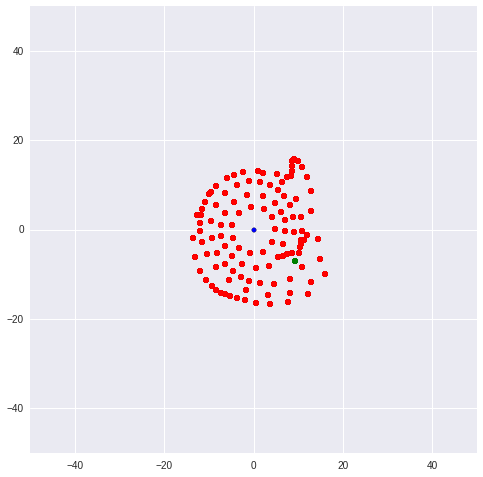

In [218]:
interact(plot, time=[0, 299])